# Field inference for multiple dipole sources

This notebook shows that it is possible to learn analytical forms like the dipole field with high accuracy, via the scalar potential and the principle of superposition. 

In this demonstration, we model the potential and field from multiple fixed sources at arbitrary locations (the inference network), but do not train the hypernetwork to learn a general additive model valid for all such source collections.

The model uses jax, equinox and optax to combine neural and analytical (autodiff) components.

In [1]:
import jax
import jax.random as jr
import jax.numpy as jnp
import equinox as eqx
import optax
import numpy as np
import matplotlib.pyplot as plt


## I. Target definition and data augmentation

We expect the neural components of the model to learn transcendental functions. The dipole field at $\mathbf{r}$ from a collection of point-like sources with moments $\mathbf{m}_i$ and positions $\mathbf{r}_i$ is computed via the scalar potential as $${\mu_0}\mathbf{H}_{\odot}(\mathbf{r}) = -\nabla\sum_{i=1}^N \underbrace{\overbrace{\frac{1}{4\pi |\mathbf{r}-\mathbf{r_i}|^2}}^{\text{Surface of 3D ball}}\overbrace{\frac{\mathbf{m}_i\cdot(\mathbf{r}-\mathbf{r_i})}{|\mathbf{r}-\mathbf{r_i}|}}^{\text{dipole term}}}_{\text{scalar potential }\psi_i}$$. 

A realistic (non-pointlike) source will have the more general form $\mathbf{H}(\mathbf{r}) = - \mathbb{N}(\mathbf{r})\mathbf{M}$ inside the source, and by Gauss' Law $\mathbf{H} \sim \mathbf{H}_\odot$ outside it. The distinguishing feature of the dipole term is the $\sim 1/r$ dependence; higher multipole terms ($1/r^2$, $1/r^3$) might also be included, but the dipole term will quickly dominate at larger $r$. Similarly, the potential in two dimensions is obtained by exchanging the surface area of the 2D ball.

We generate random samples to serve as the training data, precomputing the target potential values. Using a fixed training set helps with the stability of training, but we refresh the validation set each time its accuracy computation is needed. First, we describe the collection of sources.

In [2]:
from hypermagnetics.sources import configure



In [2]:
def scalar_potential(m, r0, r):
    core = 0.5
    d = r - r0
    d_norm = jnp.linalg.norm(d)
    m_dot_r = jnp.dot(m, d)
    close_to_source = d_norm < core
    interior = m_dot_r / core / (2 * jnp.pi * core)
    exterior = m_dot_r / d_norm / (2 * jnp.pi * d_norm)
    return jnp.where(close_to_source, interior, exterior)


def generate_total_potential(m, r0, r):
    points = jax.vmap(scalar_potential, in_axes=(None, None, 0))
    batch = jax.vmap(points, in_axes=(0, 0, None))
    potential = jax.vmap(batch, in_axes=(1, 1, None))(m, r0, r)
    return jnp.sum(potential, axis=0)


def generate_total_field(m, r0, r):
    points = jax.vmap(jax.grad(scalar_potential, argnums=2), in_axes=(None, None, 0))
    batch = jax.vmap(points, in_axes=(0, 0, None))
    potential = jax.vmap(batch, in_axes=(1, 1, None))(m, r0, r)
    return -jnp.sum(potential, axis=0)


In [3]:
def plots(x_grid, y_grid, potential, field, idx=0):
    fig = plt.figure()
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Subplot 1: Magnetic Scalar Potential
    cp = axes[0].contourf(x_grid, y_grid, potential[idx])
    # plt.colorbar(cp, ax=axes[0])
    axes[0].scatter(r0[idx, :, 0], r0[idx, :, 1], color="red")
    axes[0].quiver(
        r0[idx, :, 0],
        r0[idx, :, 1],
        m[idx, :, 0],
        m[idx, :, 1],
        angles="xy",
        scale_units="xy",
        scale=1,
        color="red",
    )
    axes[0].set_title("Magnetic Scalar Potential")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")

    # Subplot 2: Magnetic Field
    axes[1].streamplot(
        x_grid,
        y_grid,
        field[idx, :, :, 0],
        field[idx, :, :, 1],
        density=1.5,
        linewidth=1,
        arrowsize=1.5,
        arrowstyle="->",
    )
    axes[1].scatter(r0[idx, :, 0], r0[idx, :, 1], color="red")
    axes[1].quiver(
        r0[idx, :, 0],
        r0[idx, :, 1],
        m[idx, :, 0],
        m[idx, :, 1],
        angles="xy",
        scale_units="xy",
        scale=1,
        color="red",
    )
    axes[1].set_title("Magnetic Field")
    axes[1].set_xlabel("x")
    axes[1].set_ylabel("y")

    plt.tight_layout()
    plt.show()


In [57]:
M = 3
N = 1
key, subkey = jr.split(jr.PRNGKey(342 - 1), 2)
m, r0 = jnp.split(jr.normal(key=subkey, shape=(N, M, 4)), 2, axis=-1)


In [58]:
lim, res = 3, 50
x_grid, y_grid = np.meshgrid(np.linspace(-lim, lim, res), np.linspace(-lim, lim, res))
flat_grid = np.stack([x_grid.flatten(), y_grid.flatten()], axis=1)
potential = generate_total_potential(m, r0, flat_grid)
field = generate_total_field(m, r0, flat_grid)


<Figure size 640x480 with 0 Axes>

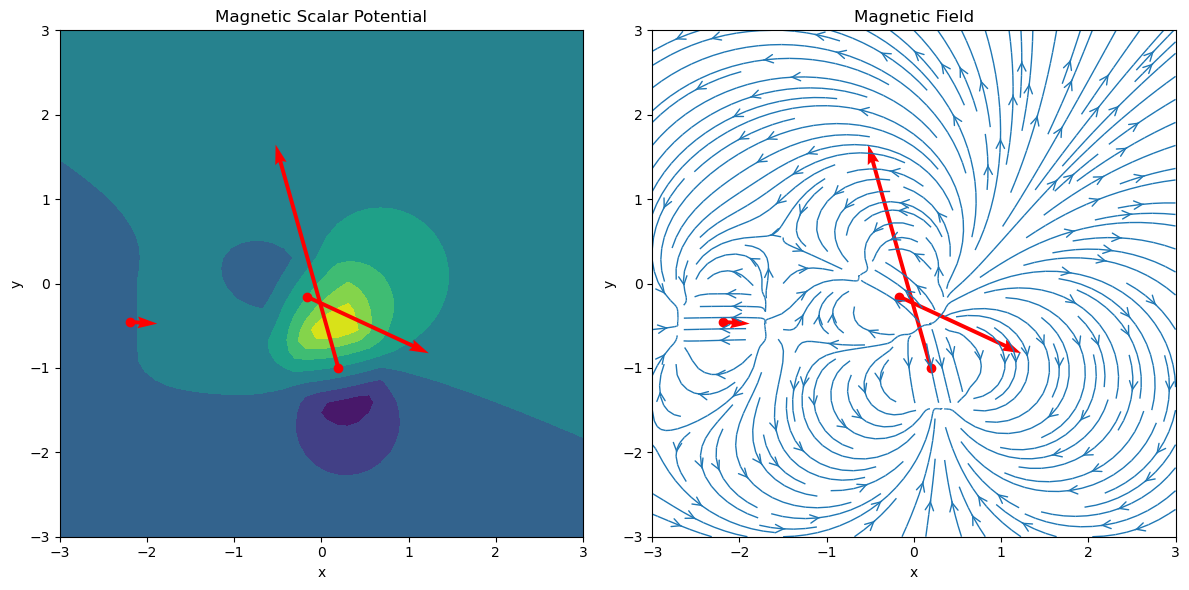

In [59]:
plots(
    x_grid,
    y_grid,
    potential.reshape(N, res, res),
    field.reshape(N, res, res, 2),
    idx=0,
)


## II. Inference

To start with, let's show that we can model the potential for this static source configuration, generalising to new field points without making any attempt at learning how the sources influence it. The grid points and evaluations we've used for plotting above are ready to be used as training data. We train an MLP network of fixed size to learn $\mu_0 \mathbf{H}$, using the relative geometric error as the target measure of accuracy. 

In [76]:
key, subkey = jr.split(key, 2)

model = eqx.nn.MLP(
    in_size=2,
    out_size="scalar",
    width_size=32,
    depth=3,
    activation=jax.nn.gelu,
    use_bias=True,
    use_final_bias=False,
    key=subkey,
)

@eqx.filter_jit
def loss(model, r, target):
    pred = jax.vmap(model)(r)
    return jnp.mean(optax.huber_loss(pred, target))

@eqx.filter_jit
def accuracy(model, r, target):
    pred = jax.vmap(model)(r)
    diff = jnp.abs(target - pred)
    return diff / jnp.abs(target) * 100

@eqx.filter_jit
def accuracy_field(model, r, target):
    pred = -jax.vmap(jax.grad(model))(r)
    diff = jnp.linalg.norm(target - pred, axis=-1)
    return diff / jnp.linalg.norm(target, axis=-1) * 100

In [77]:
print(loss(model, flat_grid, potential))


0.019172534


The training loop for the model, using the Adam optimiser and using batch (i.e. full batch) training, and logging the accuracy 100 times during the run of 10,000 epochs.

In [78]:
@eqx.filter_jit
def train_step(model, opt_state, r, y):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, r, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value

@eqx.filter_jit
def validation_set(model, subkey, size=10_000):
    mesh = jr.uniform(minval=-lim, maxval=lim, shape=(size, 2), key=subkey)
    potential = generate_total_potential(m, r0, mesh)
    field = generate_total_field(m, r0, mesh)
    return jnp.median(accuracy(model, mesh, potential)), jnp.median(accuracy_field(model, mesh, field))

optim = optax.adam(learning_rate=1e-4)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

steps = 100_000
logger = {"train_loss": [], "train_acc": [], "val_acc": [], "val_acc_field": []}
for step in range(steps):
    model, opt_state, train_loss = train_step(model, opt_state, flat_grid, potential)
    if (step % (steps / 100)) == 0:
        logger["train_loss"].append(train_loss)
        logger["train_acc"].append(jnp.median(accuracy(model, flat_grid, potential)))

        # Generate validation data
        key, subkey = jr.split(key, 2)
        val_acc, val_acc_field = validation_set(model, subkey)
        logger["val_acc"].append(val_acc)
        logger["val_acc_field"].append(val_acc_field)
    if (step % (steps / 10)) == 0:
        print(
            f"{step=}, train_loss={train_loss:.4f}, ",
            f"accuracy={logger['train_acc'][-1]:.4f}",
            f"val_accuracy={logger['val_acc'][-1]:.4f}",
            f"val_accuracy_field={logger['val_acc_field'][-1]:.4f}",
        )

key, subkey = jr.split(key, 2)
rge, _ = validation_set(model, subkey)
print(f"Final accuracy: {rge:.2f}%")


step=0, train_loss=0.0192,  accuracy=96.5717 val_accuracy=96.0233 val_accuracy_field=99.9054
step=10000, train_loss=0.0001,  accuracy=1.3334 val_accuracy=1.3220 val_accuracy_field=9.9610
step=20000, train_loss=0.0000,  accuracy=0.7286 val_accuracy=0.7408 val_accuracy_field=6.9621
step=30000, train_loss=0.0000,  accuracy=0.5318 val_accuracy=0.5128 val_accuracy_field=5.2058
step=40000, train_loss=0.0000,  accuracy=0.4497 val_accuracy=0.4248 val_accuracy_field=4.7701
step=50000, train_loss=0.0000,  accuracy=0.4222 val_accuracy=0.4177 val_accuracy_field=4.5751
step=60000, train_loss=0.0000,  accuracy=0.5613 val_accuracy=0.5684 val_accuracy_field=4.3578
step=70000, train_loss=0.0000,  accuracy=0.3616 val_accuracy=0.3425 val_accuracy_field=4.0518
step=80000, train_loss=0.0000,  accuracy=0.3414 val_accuracy=0.3465 val_accuracy_field=3.9034
step=90000, train_loss=0.0000,  accuracy=0.3234 val_accuracy=0.3182 val_accuracy_field=3.9032
Final accuracy: 0.31%


In [79]:
val_mesh = jr.uniform(minval=-lim, maxval=lim, shape=(10_000, 2), key=subkey)
val_potential = generate_total_potential(m, r0, val_mesh)
val_field = generate_total_field(m, r0, val_mesh)
print(jnp.median(accuracy(model, val_mesh, val_potential)))
print(jnp.median(accuracy_field(model, val_mesh, val_field)))

0.30699354
3.7006202


In [93]:
len(logger_potential['val_acc_field'])

100

## IIb. Evaluate magnetic field directly from model

In [88]:
key, subkey = jr.split(key, 2)

model = eqx.nn.MLP(
    in_size=2,
    out_size=2,
    width_size=32,
    depth=3,
    activation=jax.nn.gelu,
    use_bias=True,
    use_final_bias=False,
    key=subkey,
)

@eqx.filter_jit
def loss(model, r, target):
    pred = jax.vmap(model)(r)
    return jnp.mean(optax.huber_loss(pred, target))

@eqx.filter_jit
def accuracy_field(model, r, target):
    pred = jax.vmap(model)(r)
    diff = jnp.linalg.norm(target - pred, axis=-1)
    return diff / jnp.linalg.norm(target, axis=-1) * 100

In [89]:
print(loss(model, flat_grid, field))

0.043556303


In [90]:
@eqx.filter_jit
def train_step(model, opt_state, r, y):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, r, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


@eqx.filter_jit
def validation_set(model, subkey, size=10_000):
    mesh = jr.uniform(minval=-lim, maxval=lim, shape=(size, 2), key=subkey)
    field = generate_total_field(m, r0, mesh)
    return jnp.median(accuracy_field(model, mesh, field))


optim = optax.adam(learning_rate=1e-4)
opt_state = optim.init(eqx.filter(model, eqx.is_array))

steps = 100_000
logger = {"train_loss": [], "train_acc": [], "val_acc": []}
for step in range(steps):
    model, opt_state, train_loss = train_step(model, opt_state, flat_grid, field)
    if (step % (steps / 100)) == 0:
        logger["train_loss"].append(train_loss)
        logger["train_acc"].append(jnp.median(accuracy_field(model, flat_grid, field)))

        # Generate validation data
        key, subkey = jr.split(key, 2)
        logger["val_acc"].append(validation_set(model, subkey))
    if (step % (steps / 10)) == 0:
        print(
            f"{step=}, train_loss={train_loss:.4f}, ",
            f"accuracy={logger['train_acc'][-1]:.4f}",
            f"val_accuracy={logger['val_acc'][-1]:.4f}",
        )

key, subkey = jr.split(key, 2)
rge = validation_set(model, subkey)
print(f"Final accuracy: {rge:.2f}%")


step=0, train_loss=0.0436,  accuracy=106.0390 val_accuracy=105.2072
step=10000, train_loss=0.0004,  accuracy=13.5695 val_accuracy=13.4831
step=20000, train_loss=0.0001,  accuracy=9.2187 val_accuracy=9.5549
step=30000, train_loss=0.0001,  accuracy=7.8940 val_accuracy=8.0622
step=40000, train_loss=0.0001,  accuracy=6.8910 val_accuracy=7.0057
step=50000, train_loss=0.0001,  accuracy=5.9332 val_accuracy=6.2949
step=60000, train_loss=0.0001,  accuracy=5.3216 val_accuracy=5.4678
step=70000, train_loss=0.0001,  accuracy=4.9279 val_accuracy=5.0470
step=80000, train_loss=0.0001,  accuracy=4.7282 val_accuracy=4.9352
step=90000, train_loss=0.0000,  accuracy=4.6475 val_accuracy=4.8339
Final accuracy: 4.70%


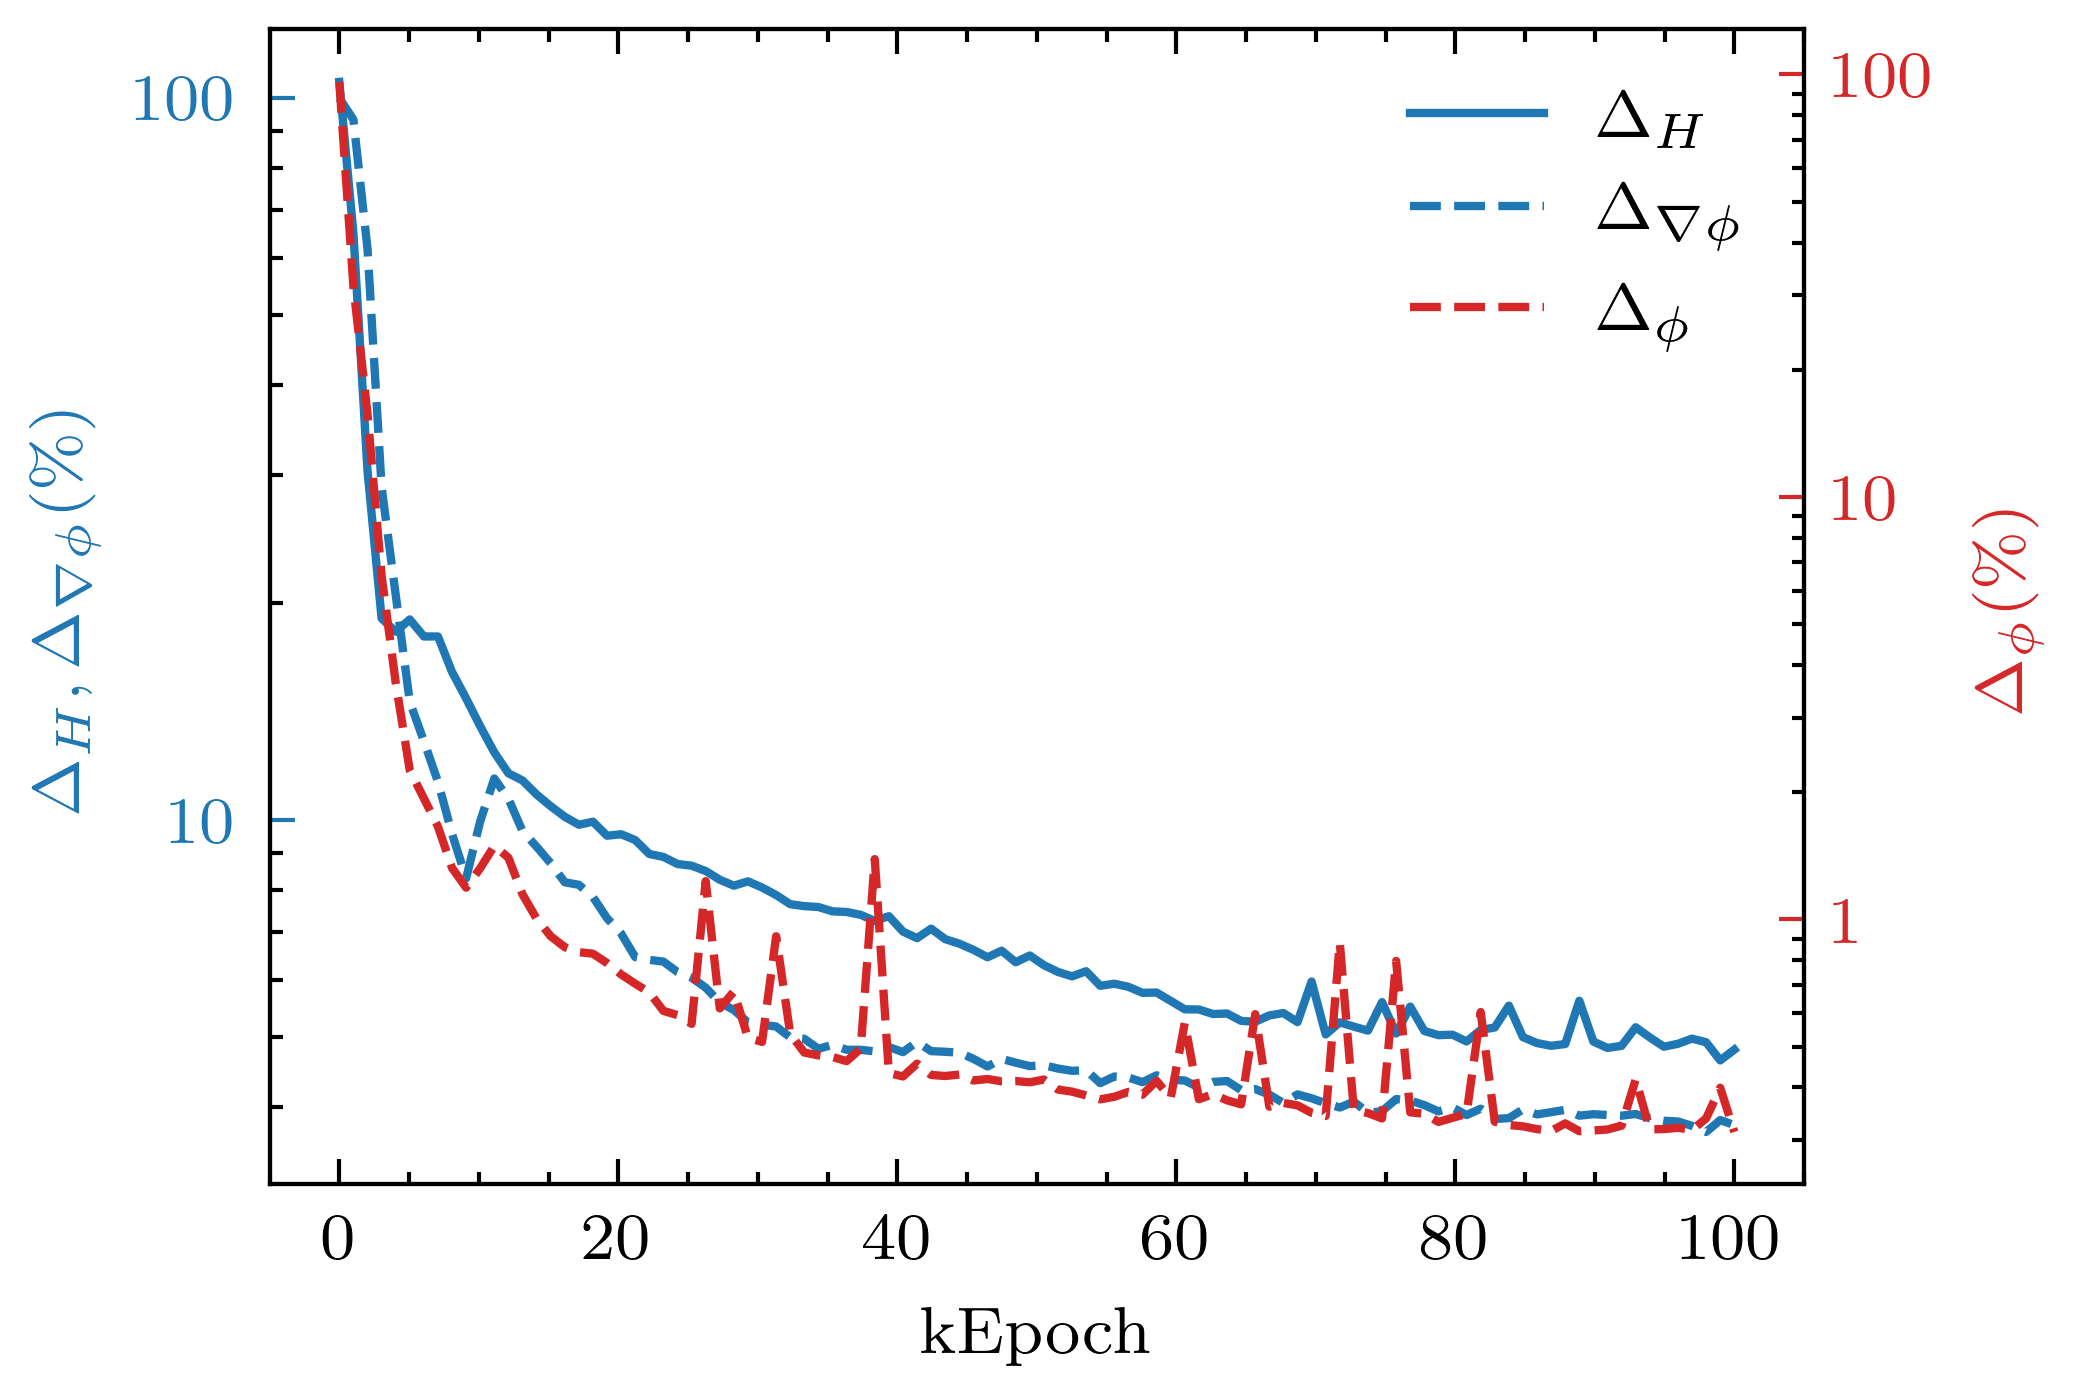

In [115]:
import scienceplots
plt.style.use(['science','ieee'])
from matplotlib.ticker import FuncFormatter

epochs = jnp.linspace(0, 100, 100)
delta_H1 = logger["val_acc"]
delta_H2 = logger_potential["val_acc_field"]
delta_phi = logger_potential["val_acc"]

# Function to format the y-axis labels
def format_func(value, tick_number):
    return f'{int(value)}'

# Creating the figure and the first axis
fig, ax1 = plt.subplots()

# Plotting the Delta_H curves on the first (left) axis
line1, = ax1.semilogy(epochs, delta_H1, label='$\Delta_H$', color='tab:blue')
line2, = ax1.semilogy(epochs, delta_H2, label="$\Delta_{\\nabla\phi}$", color='tab:blue', linestyle='--')

# Creating the second axis, sharing the same x-axis as ax1
ax2 = ax1.twinx()

# Plotting the Delta_phi curve on the second (right) axis
line3, = ax2.semilogy(epochs, delta_phi, label='$\Delta_{\phi}$', color='tab:red', linestyle='--')

# Setting the y-axis formatter
ax1.yaxis.set_major_formatter(FuncFormatter(format_func))
ax2.yaxis.set_major_formatter(FuncFormatter(format_func))

# Labels, title, and legend
ax1.set_xlabel('kEpoch')
ax1.set_ylabel('$\Delta_H, \Delta_{\\nabla\phi} (\%)$', color='tab:blue')
ax2.set_ylabel('$\Delta_{\phi} (\%)$', color='tab:red')
ax1.tick_params(axis='y', colors='tab:blue')
ax2.tick_params(axis='y', colors='tab:red')

# Combining legends from both axes
lines = [line1, line2, line3]
labels = [l.get_label() for l in lines]
ax1.legend(lines, labels, loc='upper right')

plt.show()


In [21]:
# generate random points within the limits
pred_potential = jax.vmap(model)(flat_grid)
pred_field = -jax.vmap(jax.grad(model))(flat_grid)


<Figure size 640x480 with 0 Axes>

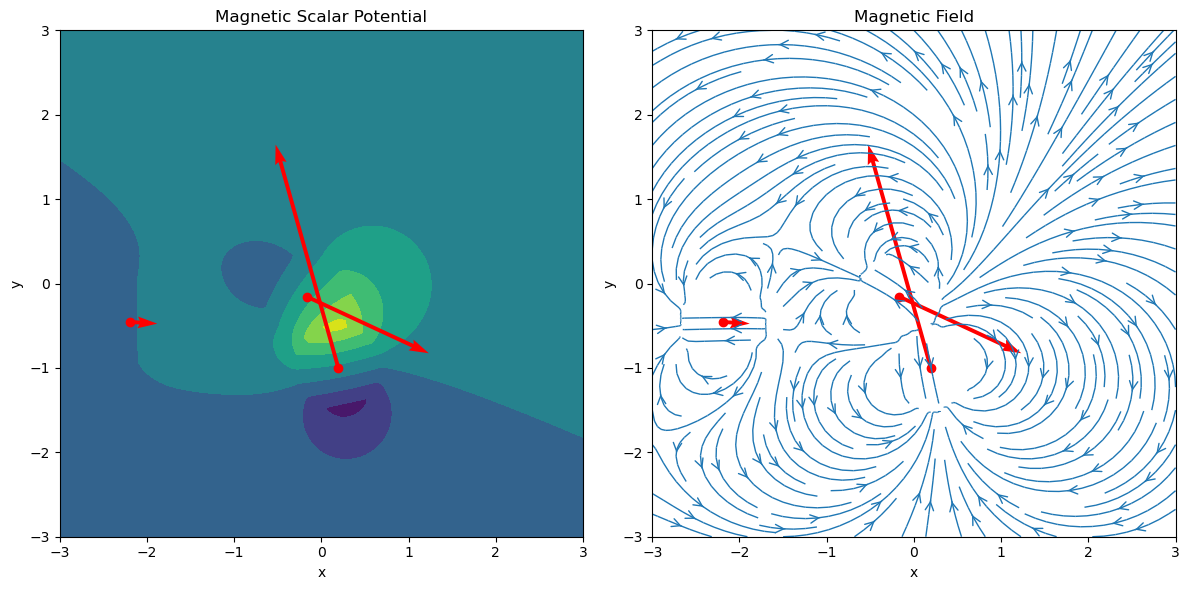

<Figure size 640x480 with 0 Axes>

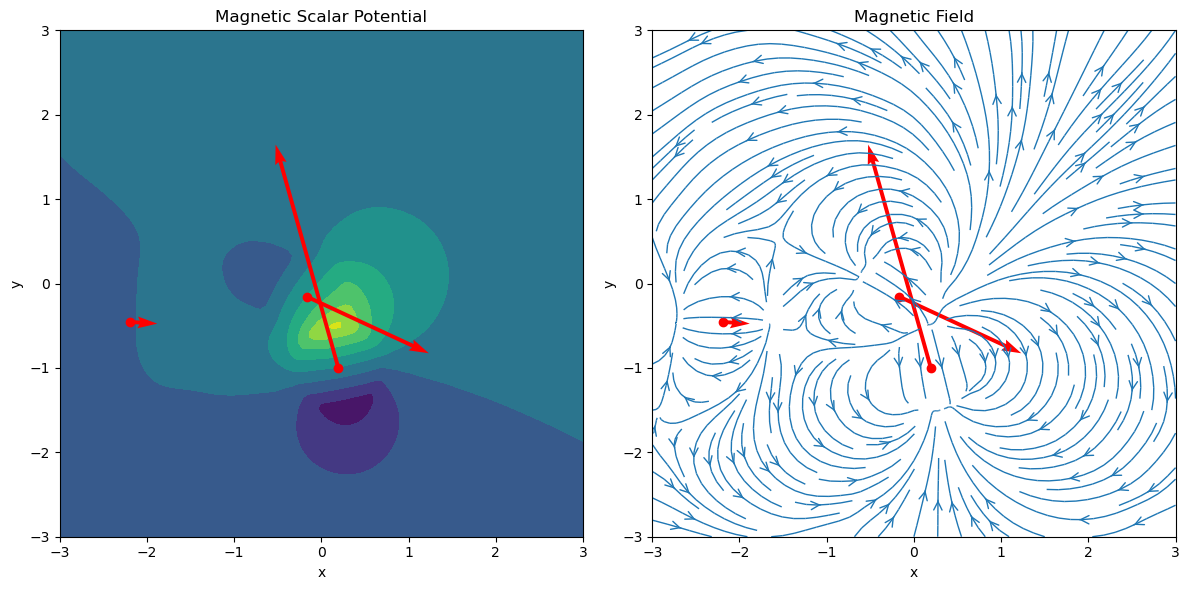

In [22]:
plots(
    x_grid,
    y_grid,
    potential.reshape(N, res, res),
    field.reshape(N, res, res, 2),
)

plots(
    x_grid,
    y_grid,
    pred_potential.reshape(1, res, res),
    pred_field.reshape(N, res, res, 2),
)


## III. Learning the dependence on magnetic moment

An MLP can evidently generalise to unseen random field point locations. But can we understand how the weights of the MLP depend on the magnetic sources? To attempt this, we create a second ('hyper'-)network, whose purpose is to receive the collection of sources and output *the weights* of the ('main') inference network. 

In [87]:
N, M = 10000, 10
key, subkey = jr.split(jr.PRNGKey(2342), 2)
m, r0 = jnp.split(jr.normal(key=subkey, shape=(N, M, 4)), 2, axis=-1)


In [88]:
lim, res = 3, 32
x_grid, y_grid = np.meshgrid(np.linspace(-lim, lim, res), np.linspace(-lim, lim, res))
flat_grid = np.stack([x_grid.flatten(), y_grid.flatten()], axis=1)
potential = generate_total_potential(m, r0, flat_grid)
field = generate_total_field(m, r0, flat_grid)


<Figure size 640x480 with 0 Axes>

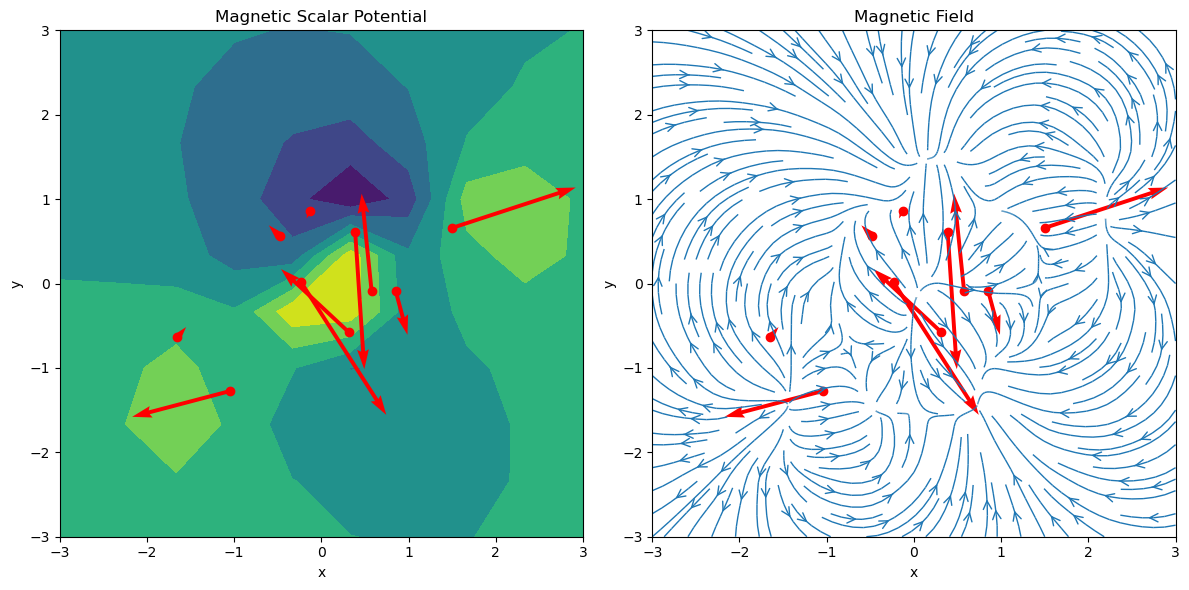

In [89]:
plots(
    x_grid,
    y_grid,
    potential.reshape(N, res, res),
    field.reshape(N, res, res, 2),
    idx=5,
)


In [60]:
# Functions for trying to modify the weights of a model directly. This didn't work :(

# def is_linear(x):
#     return isinstance(x, eqx.nn.Linear)


# def get_weights(model):
#     leaves = jax.tree_util.tree_leaves(model, is_leaf=is_linear)
#     return [x.weight for x in leaves if is_linear(x)]

# def get_partitions(model):
#     weight_shapes = [w.shape for w in get_weights(model)]
#     partition_sizes = [shape[0] * shape[1] for shape in weight_shapes]
#     partition_boundaries = jnp.cumsum(jnp.array(partition_sizes))
#     return partition_boundaries, weight_shapes

# # @jax.jit
# def build_model(model, weights):
#     partition_boundaries, weight_shapes = get_partitions(model)
#     partitioned_weights = jnp.split(weights, partition_boundaries[:-1])
#     reshaped_weights = [
#         jnp.reshape(partition, shape)
#         for partition, shape in zip(partitioned_weights, weight_shapes)
#     ]
#     return eqx.tree_at(get_weights, model, reshaped_weights)

# def __call__(self, m, r0, r):
#     m_r = jnp.concatenate([m, r0], axis=-1)
#     weights = jnp.sum(jax.vmap(self.weights)(m_r), axis=0)
#     model = build_model(self.model, weights)
#     return jax.vmap(model)(r)


In [91]:
def is_linear(x):
    return isinstance(x, eqx.nn.Linear)


def get_weights(model):
    leaves = jax.tree_util.tree_leaves(model, is_leaf=is_linear)
    return [x.weight for x in leaves if is_linear(x)]


def get_biases(model):
    leaves = jax.tree_util.tree_leaves(model, is_leaf=is_linear)
    return [x.bias for x in leaves if is_linear(x)]


@jax.jit
def reshape_params(old_params, params):
    new_params = []
    for w in old_params:
        new_params.append(jnp.reshape(params[: w.size], w.shape))
        params = params[w.size :]
    return new_params


class HyperModel(eqx.Module):
    rho: eqx.nn.MLP
    # phi: eqx.nn.Linear
    nbiases: int
    nweights: int
    model: eqx.nn.MLP = eqx.field(static=True)

    def __init__(self, width, depth, hyperkey, mainkey):
        self.model = eqx.nn.MLP(
            2, "scalar", width, depth, jax.nn.gelu, use_bias=True, key=mainkey
        )
        self.nweights = sum(w.size for w in get_weights(self.model))
        self.nbiases = sum(b.size for b in get_biases(self.model))
        nparams = self.nweights + self.nbiases
        self.rho = eqx.nn.MLP(4, nparams, nparams, 2, jax.nn.gelu, key=hyperkey)
        # self.phi = eqx.nn.Linear(nparams, nparams, key=hyperkey)

    def prepare_weights(self, m_r):
        wb = jnp.sum(jax.vmap(self.rho)(m_r), axis=0)
        # wb = self.phi(wb)
        weights, biases = wb[: self.nweights], wb[self.nweights :]
        return weights, biases

    def prepare_model(self, weights, biases):
        model = eqx.tree_at(
            get_weights, self.model, reshape_params(get_weights(self.model), weights)
        )
        model = eqx.tree_at(
            get_biases, model, reshape_params(get_biases(model), biases)
        )
        return model

    def field(self, m_r, r):
        weights, biases = self.prepare_weights(m_r)
        model = self.prepare_model(weights, biases)
        return -jax.vmap(jax.grad(model))(r)

    def __call__(self, m_r, r):
        weights, biases = self.prepare_weights(m_r)
        model = self.prepare_model(weights, biases)
        return jax.vmap(model)(r)


key, hyperkey, mainkey = jr.split(key, 3)
hypermodel = HyperModel(16, 3, hyperkey, mainkey)


In [92]:
@eqx.filter_jit
def loss(model, m_r, r, target):
    pred = jax.vmap(model, in_axes=(0, None))(m_r, r)
    return jnp.mean(optax.huber_loss(pred, target))


@eqx.filter_jit
def accuracy(model, m_r, r, target):
    pred = jax.vmap(model, in_axes=(0, None))(m_r, r)
    diff = jnp.linalg.norm(target - pred)
    return diff / jnp.linalg.norm(target) * 100


m_r = jnp.concatenate([m, r0], axis=-1)
# print(m.shape, r0.shape, flat_grid.shape, potential.shape)
print(loss(hypermodel, m_r, flat_grid, potential))
print(accuracy(hypermodel, m_r, flat_grid, potential))


1.510725
1019.9041


In [ ]:
## ATTEMPT AT SCHEDULING - DON'T USE YET

schedule = optax.warmup_cosine_decay_schedule(
    init_value=0.0,
    peak_value=1.0,
    warmup_steps=50,
    decay_steps=100,
    end_value=0.0,
)

optim = optax.chain(
    optax.clip(1.0),
    optax.adamw(learning_rate=schedule),
)
opt_state = optim.init(eqx.filter(hypermodel, eqx.is_array))


def fit(hypermodel, opt_state) -> optax.Params:
    @eqx.filter_jit
    def train_step(model, opt_state, m, r0, r, y):
        loss_value, grads = eqx.filter_value_and_grad(loss)(model, m, r0, r, y)
        updates, opt_state = optim.update(grads, opt_state, model)
        model = eqx.apply_updates(model, updates)
        return model, opt_state, loss_value

    logger = {"train_loss": [], "train_acc": [], "val_acc": []}
    for step in range(steps):
        hypermodel, opt_state, train_loss = train_step(
            hypermodel, opt_state, m, r0, flat_grid, potential
        )
        if (step % (steps / 100)) == 0:
            logger["train_loss"].append(train_loss)
            logger["train_acc"].append(
                accuracy(hypermodel, m, r0, flat_grid, potential)
            )
        if (step % (steps / 10)) == 0:
            print(
                f"{step=}, train_loss={train_loss:.4f}, ",
                f"accuracy={logger['train_acc'][-1]:.4f}",
            )

    return hypermodel


hypermodel = fit(hypermodel, opt_state)


In [93]:
m_r = jnp.concatenate([m, r0], axis=-1)


@eqx.filter_jit
def train_step(model, opt_state, m_r, r, y):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, m_r, r, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


@eqx.filter_jit
def validation_set(model, subkeys):
    m, r0 = jnp.split(jr.normal(key=subkeys.pop(), shape=(N, M, 4)), 2, axis=-1)
    # mesh = jr.uniform(minval=-lim, maxval=lim, shape=(res * res, 2), key=subkeys.pop())
    mesh = flat_grid
    potential = generate_total_potential(m, r0, mesh)
    m_r = jnp.concatenate([m, r0], axis=-1)
    return jnp.median(accuracy(model, m_r, mesh, potential))


optim = optax.adam(learning_rate=1e-5)
opt_state = optim.init(eqx.filter(hypermodel, eqx.is_array))
steps = 10_000
logger = {"train_loss": [], "train_acc": [], "val_acc": []}
for step in range(steps):
    hypermodel, opt_state, train_loss = train_step(
        hypermodel, opt_state, m_r, flat_grid, potential
    )
    if (step % (steps / 100)) == 0:
        key, *subkeys = jr.split(key, 3)
        logger["train_loss"].append(train_loss)
        logger["train_acc"].append(accuracy(hypermodel, m_r, flat_grid, potential))
        logger["val_acc"].append(validation_set(hypermodel, subkeys))
    if (step % (steps / 10)) == 0:
        print(
            f"{step=}, train_loss={train_loss:.4f}, ",
            f"accuracy={logger['train_acc'][-1]:.4f}",
            f"val_accuracy={logger['val_acc'][-1]:.4f}",
        )


step=0, train_loss=1.5107,  accuracy=897.0682 val_accuracy=870.7255
step=1000, train_loss=0.0176,  accuracy=67.1501 val_accuracy=72.1794
step=2000, train_loss=0.0133,  accuracy=58.2279 val_accuracy=64.0375
step=3000, train_loss=0.0107,  accuracy=52.2786 val_accuracy=59.2935
step=4000, train_loss=0.0088,  accuracy=47.5043 val_accuracy=55.2101
step=5000, train_loss=0.0077,  accuracy=44.2505 val_accuracy=52.9217
step=6000, train_loss=0.0068,  accuracy=41.7959 val_accuracy=52.2919
step=7000, train_loss=0.0063,  accuracy=39.9989 val_accuracy=52.1725
step=8000, train_loss=0.0058,  accuracy=38.4741 val_accuracy=54.4325


KeyboardInterrupt: 

In [75]:
def plotsv(x_grid, y_grid, m, r0, potential, field=None, idx=0):
    fig = plt.figure()
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))

    # Subplot 1: Magnetic Scalar Potential
    cp = axes[0].contourf(x_grid, y_grid, potential[idx])
    # plt.colorbar(cp, ax=axes[0])
    axes[0].scatter(r0[idx, :, 0], r0[idx, :, 1], color="red")
    axes[0].quiver(
        r0[idx, :, 0],
        r0[idx, :, 1],
        m[idx, :, 0],
        m[idx, :, 1],
        angles="xy",
        scale_units="xy",
        scale=1,
        color="red",
    )
    axes[0].set_title("Magnetic Scalar Potential")
    axes[0].set_xlabel("x")
    axes[0].set_ylabel("y")

    # Subplot 2: Magnetic Field
    if field is not None:
        axes[1].streamplot(
            x_grid,
            y_grid,
            field[idx, :, :, 0],
            field[idx, :, :, 1],
            density=1.5,
            linewidth=1,
            arrowsize=1.5,
            arrowstyle="->",
        )
        axes[1].scatter(r0[idx, :, 0], r0[idx, :, 1], color="red")
        axes[1].quiver(
            r0[idx, :, 0],
            r0[idx, :, 1],
            m[idx, :, 0],
            m[idx, :, 1],
            angles="xy",
            scale_units="xy",
            scale=1,
            color="red",
        )
        axes[1].set_title("Magnetic Field")
        axes[1].set_xlabel("x")
        axes[1].set_ylabel("y")

    plt.tight_layout()
    plt.show()


<Figure size 640x480 with 0 Axes>

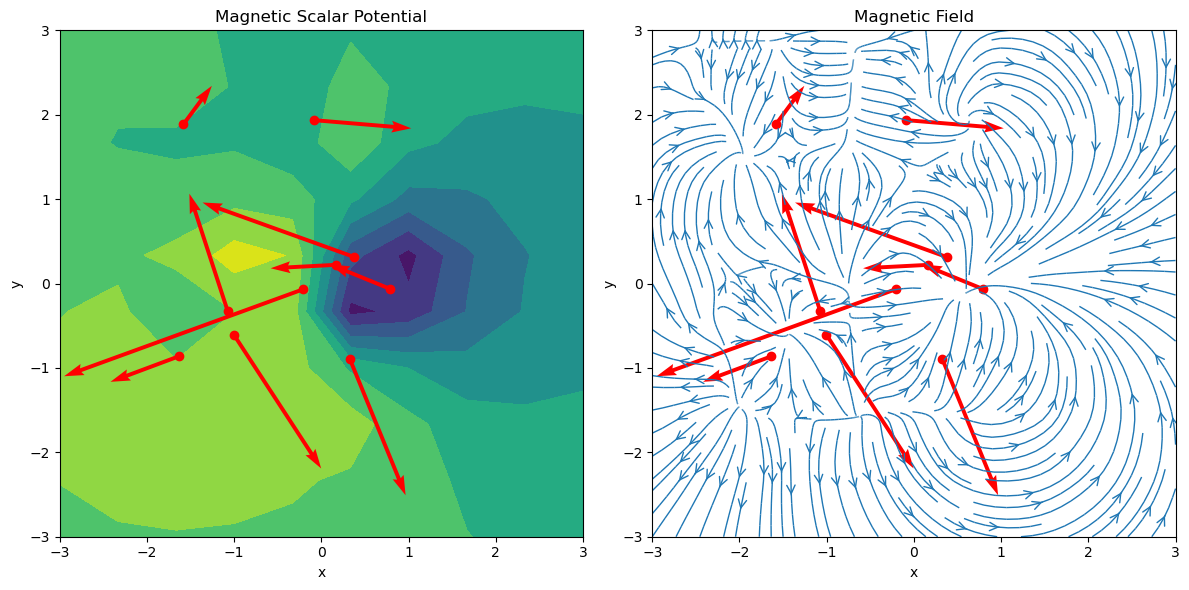

<Figure size 640x480 with 0 Axes>

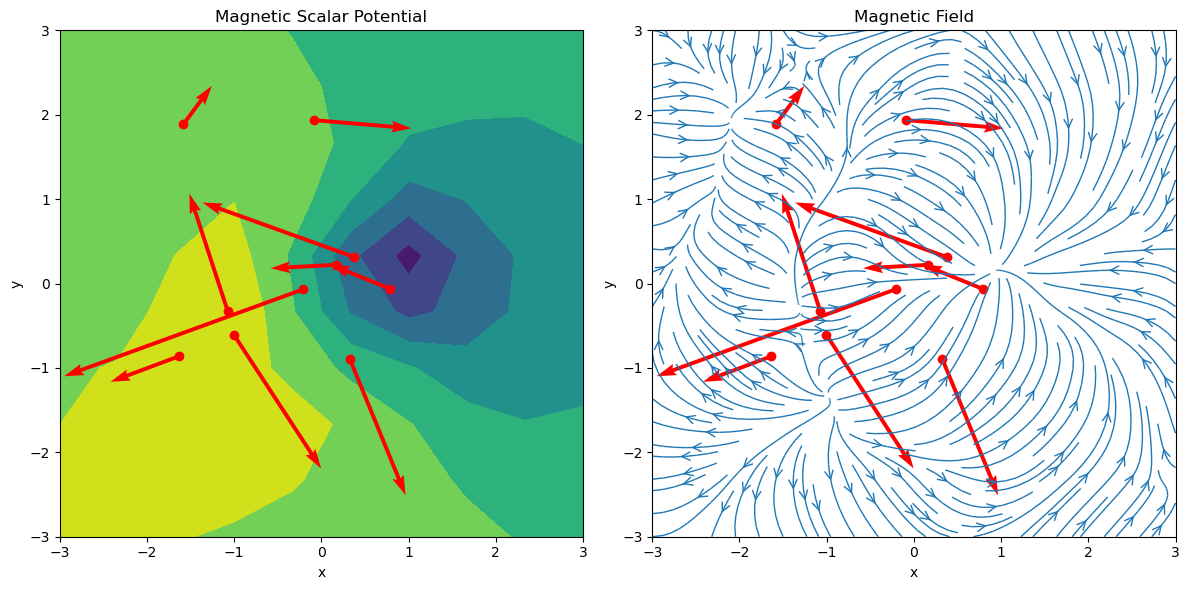

In [94]:
pred_potential = jax.vmap(hypermodel, in_axes=(0, None))(m_r, flat_grid)
pred_field = jax.vmap(hypermodel.field, in_axes=(0, None))(m_r, flat_grid)
plotsv(
    x_grid,
    y_grid,
    m,
    r0,
    potential.reshape(N, res, res),
    field.reshape(N, res, res, 2),
)
plotsv(
    x_grid,
    y_grid,
    m,
    r0,
    pred_potential.reshape(N, res, res),
    pred_field.reshape(N, res, res, 2),
)


<Figure size 640x480 with 0 Axes>

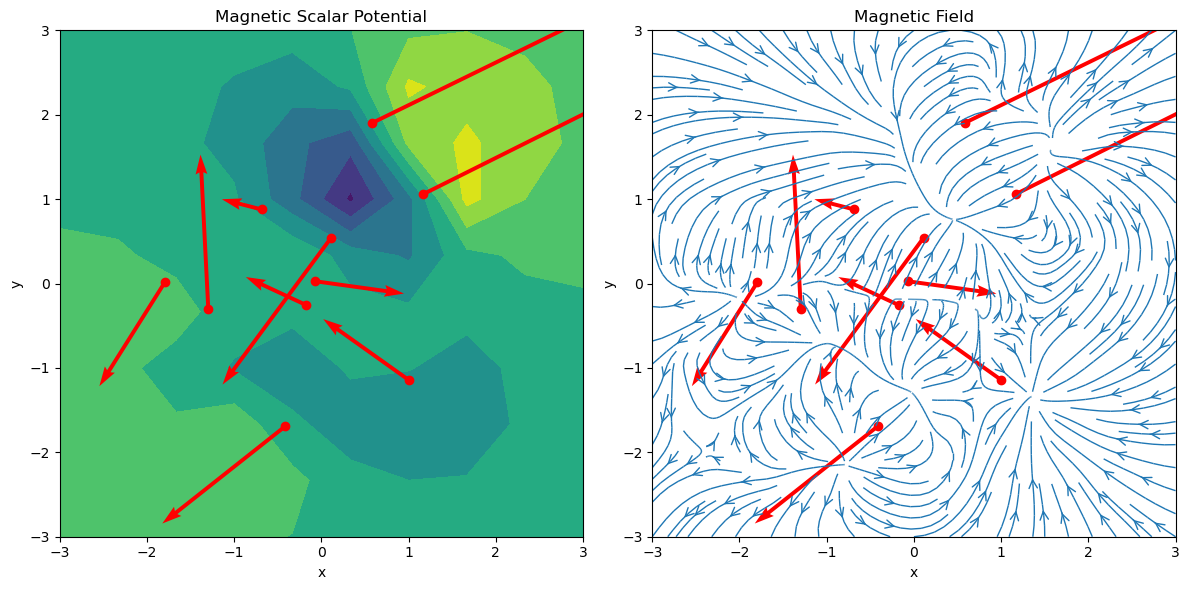

<Figure size 640x480 with 0 Axes>

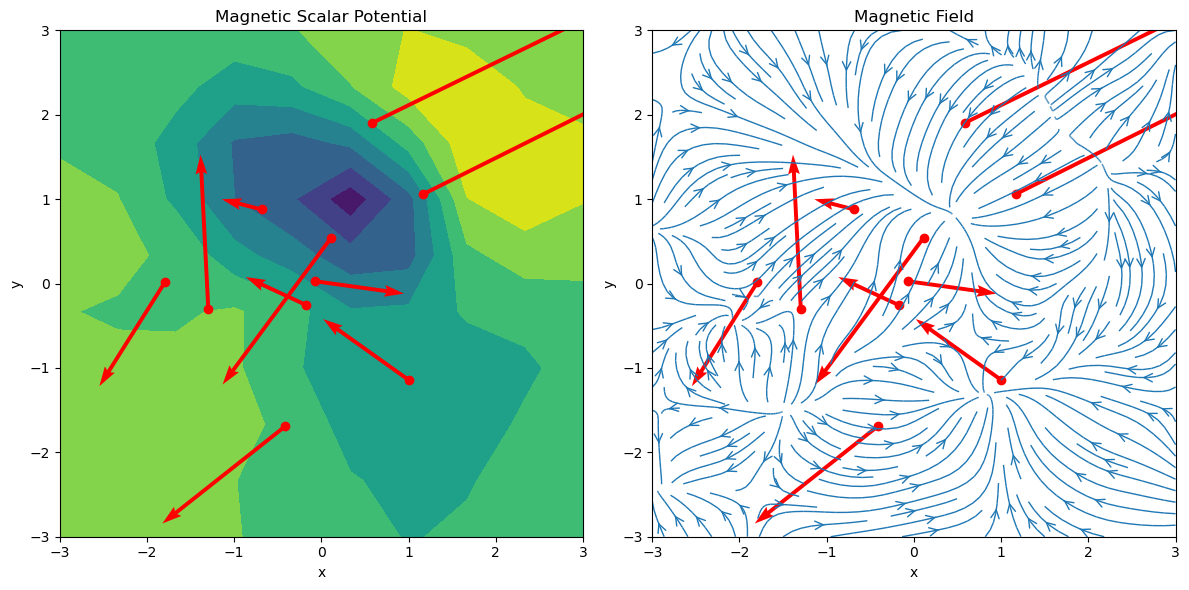

In [98]:
Nv, Mv = 1, 10
key, subkey = jr.split(jr.PRNGKey(3563 + 1), 2)
mr_v = jr.normal(key=subkey, shape=(Nv, Mv, 4))
mv, r0v = jnp.split(mr_v, 2, axis=-1)

val_potential = generate_total_potential(mv, r0v, flat_grid)
val_field = generate_total_field(mv, r0v, flat_grid)

pred_potential = jax.vmap(hypermodel, in_axes=(0, None))(mr_v, flat_grid)
pred_field = jax.vmap(hypermodel.field, in_axes=(0, None))(mr_v, flat_grid)

plotsv(
    x_grid,
    y_grid,
    mv,
    r0v,
    val_potential.reshape(Nv, res, res),
    val_field.reshape(Nv, res, res, 2),
)
plotsv(
    x_grid,
    y_grid,
    mv,
    r0v,
    pred_potential.reshape(Nv, res, res),
    pred_field.reshape(Nv, res, res, 2),
)


## Chained Model

In [ ]:
class ChainModel(eqx.Module):
    sources: eqx.nn.MLP
    field: eqx.nn.MLP

    def __init__(self, embed_size, width, depth, hyperkey, mainkey):
        self.sources = eqx.nn.MLP(
            4, embed_size, width, depth, jax.nn.gelu, key=hyperkey
        )
        self.field = eqx.nn.MLP(
            embed_size + 2, "scalar", width, depth, jax.nn.gelu, key=mainkey
        )

    def __call__(self, m, r0, r):
        m_r = jnp.concatenate([m, r0], axis=-1)
        embedding = jnp.sum(jax.vmap(self.sources)(m_r), axis=0)
        embedding_expanded = jnp.broadcast_to(
            embedding, (r.shape[0], embedding.shape[0])
        )
        embedded_r = jnp.concatenate([embedding_expanded, r], axis=-1)
        return jax.vmap(self.field)(embedded_r)


key, hyperkey, mainkey = jr.split(key, 3)
chainmodel = ChainModel(64, 64, 3, hyperkey, mainkey)


In [ ]:
@eqx.filter_jit
def loss(model, m, r0, r, target):
    pred = jax.vmap(model, in_axes=(0, 0, None))(m, r0, r)
    return jnp.mean(optax.l2_loss(pred.squeeze(), target.squeeze()))


print(m.shape, r0.shape, flat_grid.shape, potential.shape)
print(loss(chainmodel, m, r0, flat_grid, potential))
print(accuracy(chainmodel, m, r0, flat_grid, potential))


In [ ]:
@eqx.filter_jit
def train_step(model, opt_state, m, r0, r, y):
    loss_value, grads = eqx.filter_value_and_grad(loss)(model, m, r0, r, y)
    updates, opt_state = optim.update(grads, opt_state, model)
    model = eqx.apply_updates(model, updates)
    return model, opt_state, loss_value


@eqx.filter_jit
def validation_set(model, subkeys, size=100):
    m, r0 = jnp.split(jr.normal(key=subkeys.pop(), shape=(N, M, 4)), 2, axis=-1)
    mesh = jr.normal(key=subkeys.pop(), shape=(size, 2))
    # mesh = flat_grid
    potential = generate_total_potential(m, r0, mesh)
    return jnp.median(accuracy(model, m, r0, mesh, potential))


optim = optax.adam(learning_rate=0.001)
opt_state = optim.init(eqx.filter(chainmodel, eqx.is_array))
steps = 1_000
logger = {"train_loss": [], "train_acc": [], "val_acc": []}
for step in range(steps):
    chainmodel, opt_state, train_loss = train_step(
        chainmodel, opt_state, m, r0, flat_grid, potential
    )
    if (step % (steps / 100)) == 0:
        key, *subkeys = jr.split(key, 3)
        logger["train_loss"].append(train_loss)
        logger["train_acc"].append(accuracy(chainmodel, m, r0, flat_grid, potential))
        logger["val_acc"].append(validation_set(chainmodel, subkeys))
    if (step % (steps / 10)) == 0:
        print(
            f"{step=}, train_loss={train_loss:.4f}, ",
            f"accuracy={logger['train_acc'][-1]:.4f}",
            f"val_accuracy={logger['val_acc'][-1]:.4f}",
        )
